In [ ]:
라이브러리 임포트

In [2]:
import cv2
import numpy as np
from matplotlib import pylab as pylab

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac

In [ ]:
Scikit-image 사용

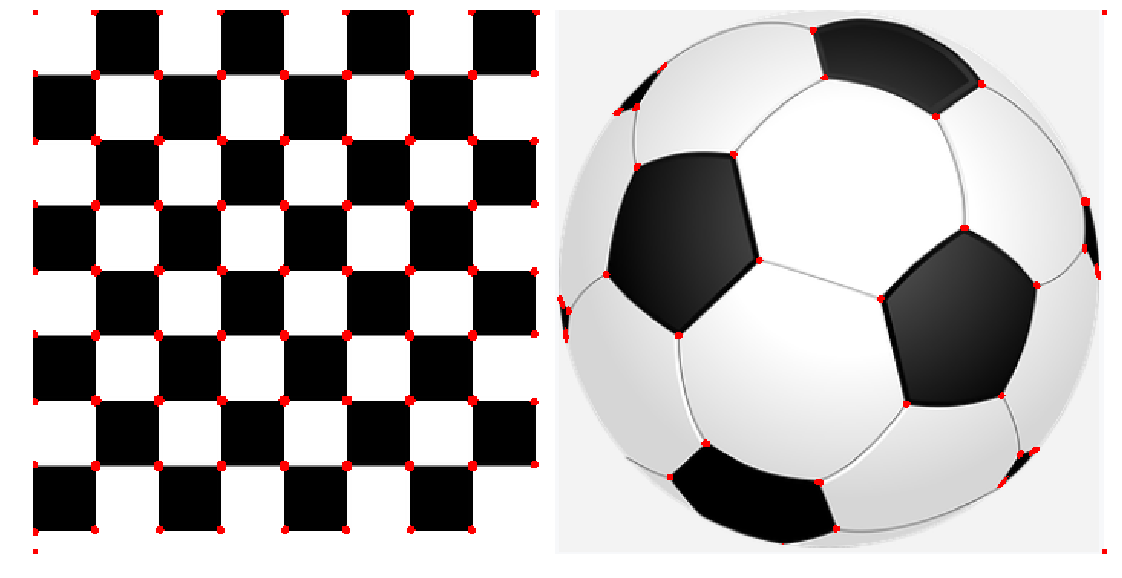

In [3]:
image = imread('../images/chess_football.png') #컬러 영상
image_gray = rgb2gray(image)
coordinates = corner_harris(image_gray, k =0.001)
image[coordinates>0.01*coordinates.max()]=[255,0,0,255]

pylab.figure(figsize=(20,10)), pylab.imshow(image), pylab.axis('off')
pylab.show()

In [ ]:
서브 화소 정확도 사용

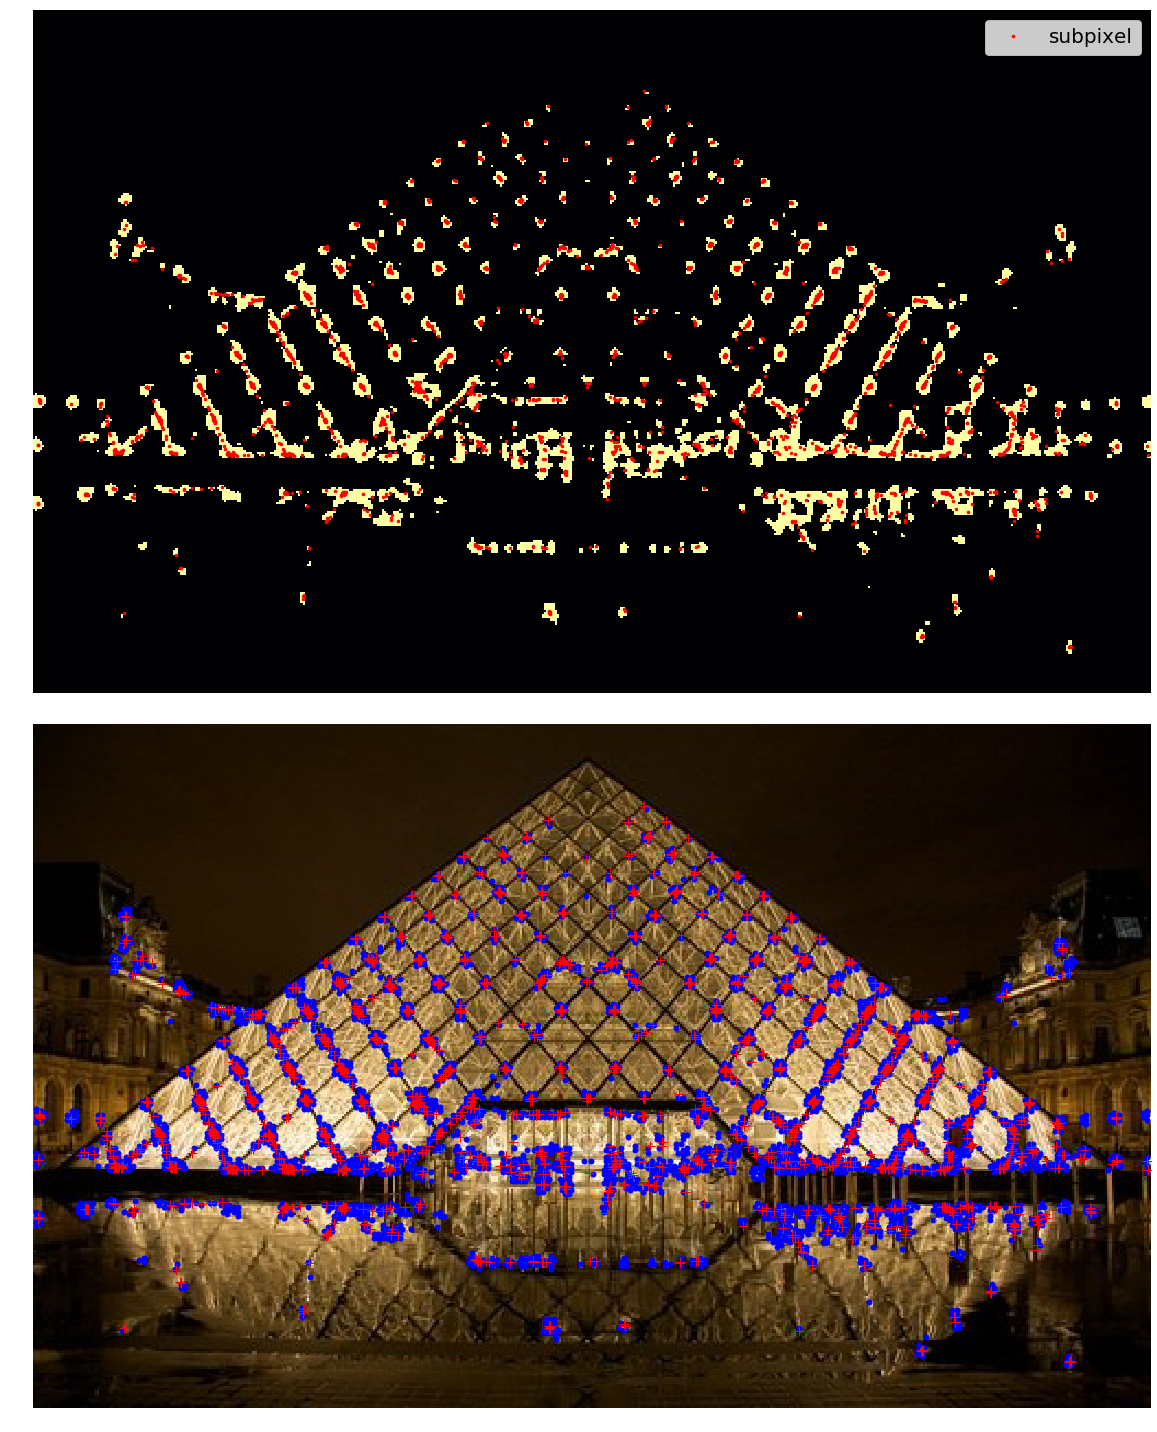

(None, None)

In [4]:
image = imread('../images/pyramids2.jpg')
image_gray = rgb2gray(image)
coordinates = corner_harris(image_gray, k =0.001)
coordinates[coordinates > 0.03*coordinates.max()] = 255
corners = corner_peaks(coordinates)
subpixs = corner_subpix(image_gray, corners, window_size=11)

pylab.figure(figsize=(20,20))
pylab.subplot(211), pylab.imshow(coordinates, cmap='inferno')
pylab.plot(subpixs[:, 1], subpixs[:, 0], 'r.', markersize=5, label='subpixel')
pylab.legend(prop={'size': 20}), pylab.axis('off')

pylab.subplot(212), pylab.imshow(image, interpolation='nearest')
pylab.plot(corners[:, 1], corners[:, 0], 'bo', markersize=5)
pylab.plot(subpixs[:, 1], subpixs[:, 0], 'r+', markersize=10)
pylab.axis('off')
pylab.tight_layout(), pylab.show()

In [ ]:
해리스 코너 특징을 사용한 강건한 영상 매칭

(<Figure size 1440x720 with 1 Axes>,
 (-0.5, 1079.5, 809.5, -0.5))

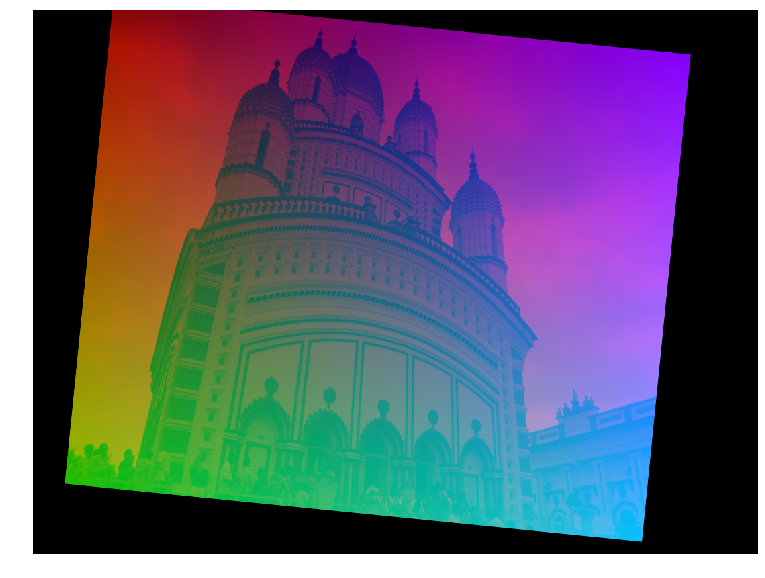

In [46]:
temple = rgb2gray(img_as_float(imread('../images/temple.jpg')))
image_original = np.zeros(list(temple.shape) + [3])
image_original[..., 0] = temple

mgrid = np.mgrid[0:image_original.shape[0], 0:image_original.shape[1]]
gradient_row, gradient_col = (mgrid / float(image_original.shape[0]))
image_original[..., 1] = gradient_row
image_original[..., 2] = gradient_col
image_original = rescale_intensity(image_original) # 밝기 조정

# 와핑 영상 생성- 크기 변경, 회전, 평행 이동
affine_trans = AffineTransform(scale=(0.8, 0.9), rotation=0.1, \
                               translation=(120, -20))
image_warped = warp(image_original, affine_trans .inverse, \
                    output_shape=image_original.shape)

image_original_gray = rgb2gray(image_original) # 명암도 영상
image_warped_gray = rgb2gray(image_warped)

In [ ]:
해리스 코너 추출

In [33]:
coordinates = corner_harris(image_original_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_original = corner_peaks(coordinates, threshold_rel=0.0001, \
                                    min_distance=5)
coordinates = corner_harris(image_warped_gray)
coordinates[coordinates > 0.01*coordinates.max()] = 1
coordinates_warped = corner_peaks(coordinates, threshold_rel=0.0001, \
                                  min_distance=5)

In [ ]:
서브 화소 코너 위치 결정

In [34]:
coordinates_original_subpix = \
            corner_subpix(image_original_gray, coordinates_original, window_size=9)
coordinates_warped_subpix = \
            corner_subpix(image_warped_gray, coordinates_warped, window_size=9)

# 중심 화소까지의 거리에 따라 화소 가중치 계산
def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g_w = np.zeros(y.shape, dtype = np.double)
    g_w[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g_w /= 2 * np.pi * sigma * sigma
    return g_w

def match_corner(coordinates, window_ext=3):
    row, col = np.round(coordinates).astype(np.intp)
    window_original = image_original[row-window_ext:row+window_ext+1, \
                                     col-window_ext:col+window_ext+1, :]
    
    # 중심 화소까지의 거리에 따른 화소의 가중치
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))
    
    #왜곡 영상에서 모든 코너에 대한 차 제곱의 합 계산
    SSDs = []
    for row, col in coordinates_warped:
        window_warped = image_warped[row-window_ext:row+window_ext+1, \
                                     col-window_ext:col+window_ext+1, :]
        if window_original.shape == window_warped.shape:
            SSD = np.sum(weights * (window_original - window_warped)**2)
            SSDs.append(SSD)
    
    # 일치관계로서 최소 SSD로 코너 사용
    min_idx = np.argmin(SSDs) if len(SSDs) > 0 else -1
    if min_idx >= 0: return coordinates_warped_subpix[min_idx] 
    else: return [None]

In [ ]:
중심 화소까지의 거리에 따른 화소의 가중치

In [42]:
# 제곱 차 가중 합계를 사용하여 일치 관계 찾기
source, destination = [], []
for coordinates in coordinates_original_subpix:
    coordinates1 = match_corner(coordinates)
    if any(coordinates1) and len(coordinates1) > 0 \
                         and not all(np.isnan(coordinates1)):
        source.append(coordinates)
        destination.append(coordinates1)
        
source = np.array(source)
destination = np.array(destination)

# 모든 좌표를 이용하여 어파인 변환 모델 추정
model = AffineTransform()
model.estimate(source, destination)

# 란삭 어파인 변환 모델 강력 추정
model_robust, inliers = ransac((source, destination), AffineTransform, \
                               min_samples=3, residual_threshold=2, max_trials=100)
outliers = inliers == False

C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in longlong_scalars
  app.launch_new_instance()
C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in longlong_scalars


In [ ]:
모든 좌표를 이용하여 어파인 변환 모델 추정

In [ ]:
model = AffineTransform()
model.estimate(source, destination)

In [ ]:

# 란삭 어파인 변환 모델 강력 추정
model_robust, inliers = ransac((source, destination), AffineTransform, \
                               min_samples=3, residual_threshold=2, max_trials=100)
outliers = inliers == False

In [ ]:
참과 추정된 변환 매개 변수 비교

In [43]:
print(affine_trans.scale, affine_trans.translation, affine_trans.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)
# .8, 0.9) [120. -20.] 0.09999999999999999
# (0.8982412101241938, 0.8072777593937359) [-20.45123966 114.92297156]
-0.10225420334222499
# (0.9001524425730123, 0.8000362790749186) [-19.87491292 119.83016533]
-0.09990858564132579

(0.8, 0.9) [120. -20.] 0.09999999999999999
(0.8982412101241938, 0.8072777593937359) [-20.45123966 114.92297156] -0.10225420334222499
(0.9001353363282479, 0.8003205626626717) [-19.96333913 119.61338834] -0.09986782740627426


-0.09990858564132579

In [ ]:
대응 관계 시각화

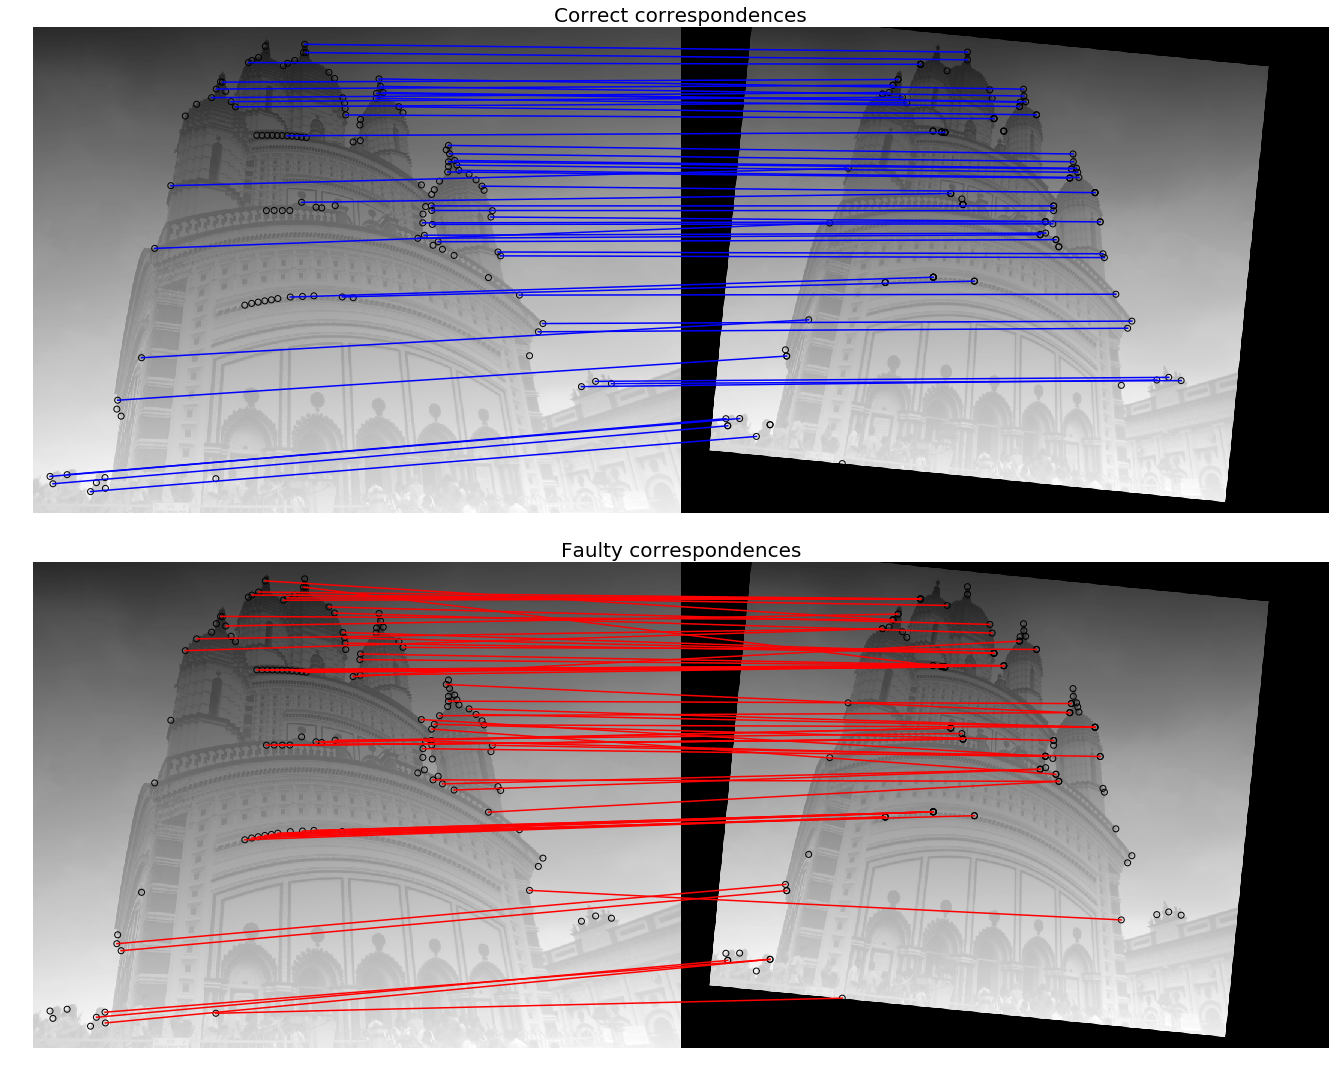

In [45]:
from skimage.feature import plot_matches

fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20,15))
inlier_idxs = np.nonzero(inliers)[0]
outlier_idxs = np.nonzero(outliers)[0]

pylab.gray()
plot_matches(axes[0], image_original_gray, image_warped_gray, source, \
             destination, np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
axes[0].axis('off'), axes[0].set_title('Correct correspondences', size=20)
plot_matches(axes[1], image_original_gray, image_warped_gray, source, \
             destination, np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
axes[1].axis('off'), axes[1].set_title('Faulty correspondences', size=20)
fig.tight_layout()
pylab.show()